In [20]:
import numpy as np

# Class Example
# A_payoff = np.array([[3, 1, 2], 
#                      [4, 0, 6]])

# B_payoff = np.array([[5, 1, 4], 
#                      [1, 3, 2]])

A_payoff = np.array([[1, 2, 3, 3], 
                     [3, 4, 2, 4],
                     [1, 2, 5, 2]])

B_payoff = np.array([[5, 2, 4, 1], 
                     [0, 1, 5, 2],
                     [3, 6, 2, 3]])

def best_response_to_average_strategy(payoff_matrix, opponent_avg_strategy):
    """
    Calculate the best response to the opponent's average strategy.
    """
    # Calculate the expected utility for each strategy
    expected_utilities = payoff_matrix @ opponent_avg_strategy
    # The best response is the strategy with the highest expected utility
    return np.argmax(expected_utilities)

def fictitious_play(A_payoff, B_payoff, iterations=100000):
    """
    Fictitious Play algorithm for games where players have a different number of strategies.
    """
    num_strategies_A = A_payoff.shape[0]  # Number of strategies for Player A
    num_strategies_B = B_payoff.shape[1]  # Number of strategies for Player B

    # Initialize strategy counts for each player
    strategy_counts_A = np.ones(num_strategies_A)
    strategy_counts_B = np.ones(num_strategies_B)

    for _ in range(iterations):
        # print(strategy_counts_A, strategy_counts_B)
        # Calculate the average strategy for each player
        average_strategy_A = strategy_counts_A / np.sum(strategy_counts_A)
        average_strategy_B = strategy_counts_B / np.sum(strategy_counts_B)

        # Player A best responds to Player B's average strategy
        best_response_A = best_response_to_average_strategy(A_payoff, average_strategy_B)
        # Player B best responds to Player A's average strategy
        best_response_B = best_response_to_average_strategy(B_payoff.T, average_strategy_A)

        # Update the strategy counts
        strategy_counts_A[best_response_A] += 1
        strategy_counts_B[best_response_B] += 1

    # Calculate the final average strategies
    final_average_strategy_A = strategy_counts_A / np.sum(strategy_counts_A)
    final_average_strategy_B = strategy_counts_B / np.sum(strategy_counts_B)

    return final_average_strategy_A, final_average_strategy_B

# Run the algorithm with the provided payoff matrices
final_avg_strategy_A, final_avg_strategy_B = fictitious_play(A_payoff, B_payoff)
print(final_avg_strategy_A.round(3)); print(final_avg_strategy_B.round(3))




[0.    0.497 0.503]
[0.  0.6 0.4 0. ]


In [21]:
import numpy as np

# Number of points for the simulation
num_points = 1000000

# Generate random points
x = np.random.uniform(0, 1, num_points)
y = np.random.uniform(0, 1, num_points)

# Count points inside the quarter circle
inside_circle = np.sum(x**2 + y**2 <= 1)

# Estimate of Pi
pi_estimate = 4 * inside_circle / num_points
pi_estimate

3.140424

In [ ]:
# To quantify the uncertainty in a numerical estimation like the mean over a uniform distribution 
# of points, you can use the standard error of the mean (SEM). The SEM is the standard deviation of the
# sample distribution of the mean, and it provides a measure of how far the estimated mean is likely to 
# be from the true mean if you were to repeat the experiment multiple times.

In [30]:
num_points = 1000000

X = np.random.uniform(0, 1, num_points)

mean_sq_cos = np.mean(np.cos(X) ** 2)

std_dev_sq_cos = np.std(np.cos(X) ** 2)

# Calculate the standard error of the mean (SEM)
sem_sq_cos = std_dev_sq_cos / np.sqrt(num_points)

mean_sq_cos, sem_sq_cos


(0.7276213579720239, 0.00022281787394583293)

In [72]:
from scipy.stats import norm
from scipy.integrate import quad
import numpy as np

# Parameters for the normal distributions f and g
mu_f, sigma_f = 0, 1 # Standard normal for f
nu_g, tau_g = 0, 1 # Standard normal for g

# Define the probability density functions for f and g
def f(x):
    return norm.pdf(x, mu_f, sigma_f)

def g(x):
    return norm.pdf(x, nu_g, tau_g)

# KL divergence function for normal distributions
def kl_divergence(f, g, mu_f, sigma_f, nu_g, tau_g):
    # Closed-form solution for KL divergence between two normal distributions
    return np.log(tau_g/sigma_f) + (sigma_f**2 + (mu_f - nu_g)**2) / (2 * tau_g**2) - 0.5

# Calculate the KL divergence
kl_div = kl_divergence(f, g, mu_f, sigma_f, nu_g, tau_g)
kl_div


0.0

In [113]:
import numpy as np
import matplotlib.pyplot as plt

class BanditArm:
    def __init__(self, mean):
        self.mean = mean
        self.estimated_value = 0
        self.n_pulls = 0

    def pull(self):
        # Pulling the arm returns a reward from a normal distribution around the true mean.
        return np.random.randn() + self.mean

    def update_estimated_value(self, reward):
        # Update the estimated value using incremental formula
        self.n_pulls += 1
        self.estimated_value = self.estimated_value + (1 / self.n_pulls) * (reward - self.estimated_value)

class EpsilonGreedyStrategy:
    def __init__(self, epsilon, bandits):
        self.epsilon = epsilon
        self.bandits = bandits

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.bandits)
        else:
            return max(self.bandits, key=lambda b: b.estimated_value)
        
class UCBBanditStrategy:
    def __init__(self, bandits):
        self.bandits = bandits
        self.total_pulls = 0

    def select_arm(self):
        self.total_pulls += 1
        ucb_values = [b.estimated_value + np.sqrt(2 * np.log(self.total_pulls) / (b.n_pulls + 1)) for b in self.bandits]
        return self.bandits[np.argmax(ucb_values)]


In [138]:
def k_bandit_problem(k, epsilon, strat, true_means, n_steps):
    bandits = [BanditArm(mean) for mean in true_means]
    if strat == 'EpsilonGreedy':
        strategy = EpsilonGreedyStrategy(epsilon, bandits)
    elif strat == 'UCB':
        strategy = UCBBanditStrategy(bandits)

    rewards = []
    regrets = []
    total_regret = 0
    optimal_value = max(true_means)

    for _ in range(n_steps):
        selected_bandit = strategy.select_arm()
        reward = selected_bandit.pull()
        selected_bandit.update_estimated_value(reward)
        rewards.append(reward)

        regret = optimal_value - reward
        total_regret += regret
        regrets.append(total_regret)

    return rewards, bandits, regrets

Total Reward: 1725.8518748284746
Average Reward: 1.7258518748284732
Bandit 1: Estimated Value: 0.8932436938679326
Bandit 2: Estimated Value: 2.027587264658862


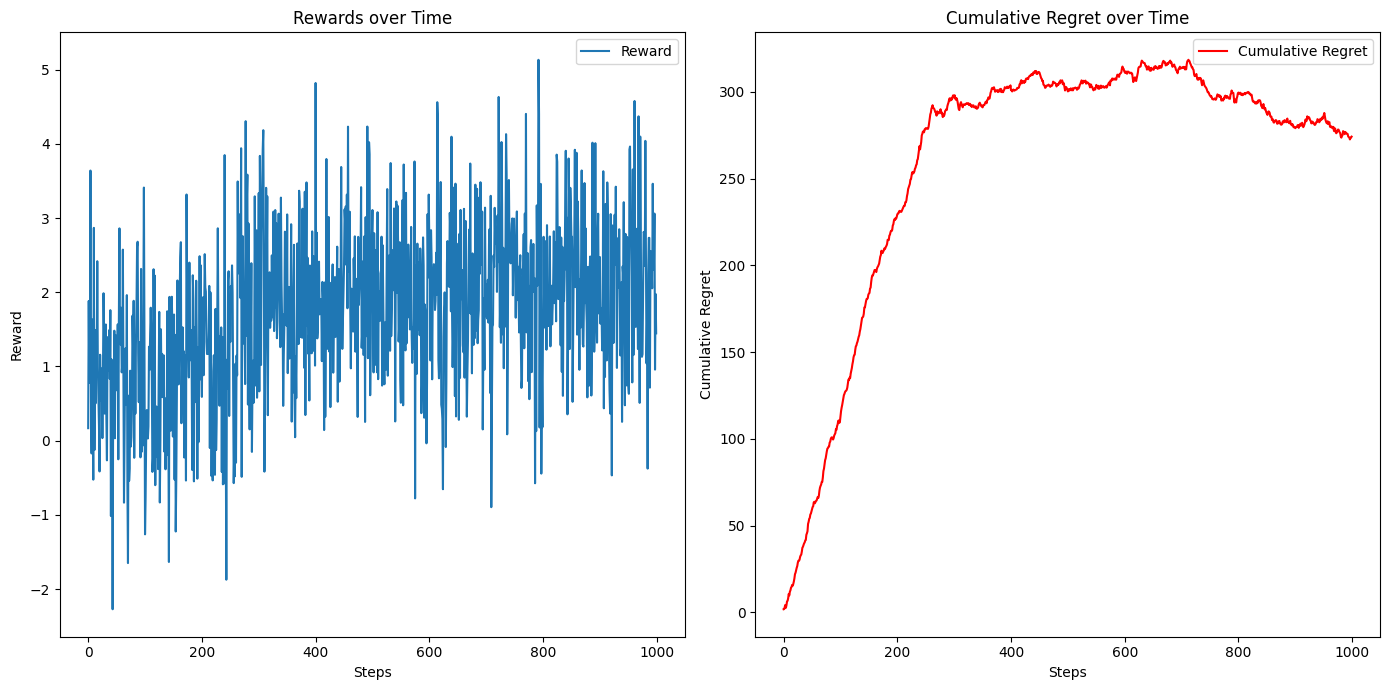

In [144]:
k = 2
epsilon = 0.01  # 10% of the time explore
true_means = [1.0, 2.0]  # True means of the rewards for each bandit
n_steps = 1000  # Number of steps to simulate

# Run the simulation
rewards, bandits, regrets = k_bandit_problem(k, epsilon, 'EpsilonGreedy', true_means, n_steps)

# Results
total_reward = sum(rewards)
average_reward = np.mean(rewards)
print(f'Total Reward: {total_reward}')
print(f'Average Reward: {average_reward}')

for i, bandit in enumerate(bandits):
    print(f'Bandit {i+1}: Estimated Value: {bandit.estimated_value}')
    
# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the rewards over time
plt.subplot(1, 2, 1)
plt.plot(rewards, label='Reward')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title('Rewards over Time')
plt.legend()

# Plot the cumulative regret over time
plt.subplot(1, 2, 2)
plt.plot(regrets, label='Cumulative Regret', color='red')
plt.xlabel('Steps')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret over Time')
plt.legend()

plt.tight_layout()
plt.show()

Total Reward: 1968.7782339498385
Average Reward: 1.9687782339498374
Bandit 1: Estimated Value: 0.9470618632757279
Bandit 2: Estimated Value: 1.9801421167379216


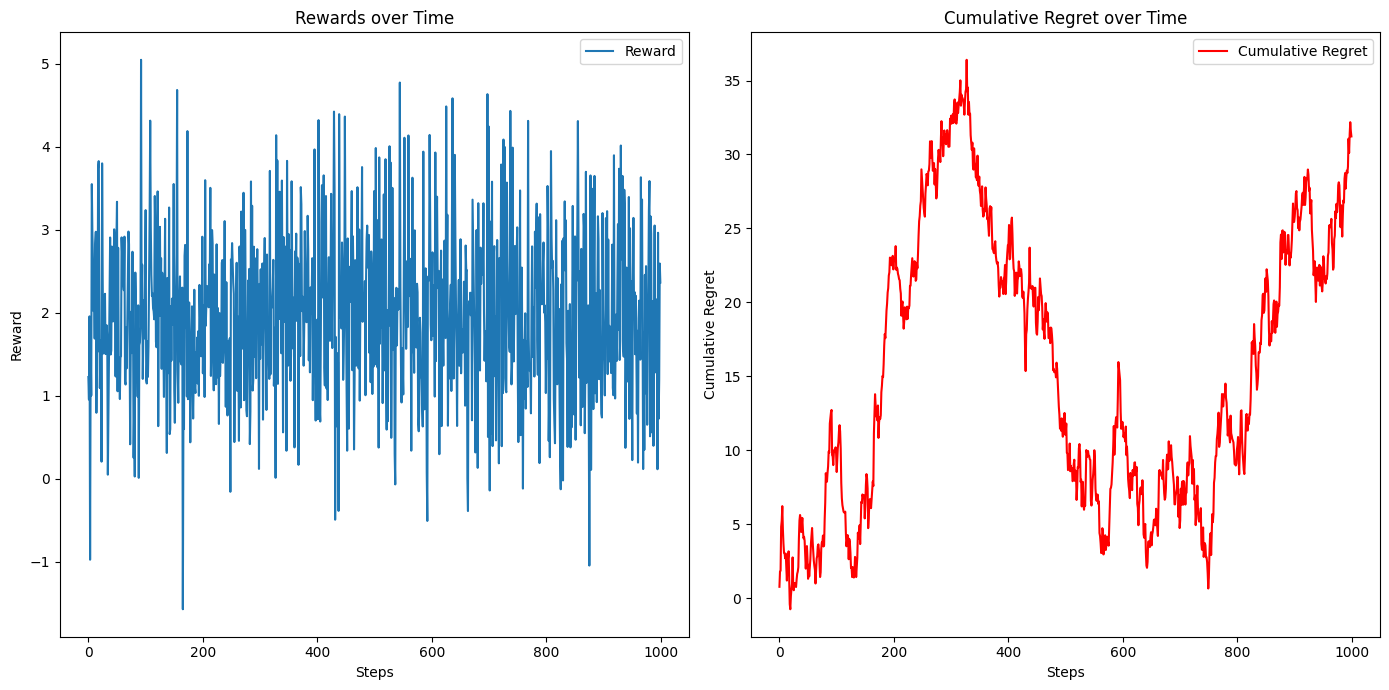

In [155]:
k = 2
epsilon = 0.1  # 10% of the time explore
true_means = [1.0, 2.0]  # True means of the rewards for each bandit
n_steps = 1000  # Number of steps to simulate

# Run the simulation
rewards, bandits, regrets = k_bandit_problem(k, epsilon, 'UCB', true_means, n_steps)

# Results
total_reward = sum(rewards)
average_reward = np.mean(rewards)
print(f'Total Reward: {total_reward}')
print(f'Average Reward: {average_reward}')

for i, bandit in enumerate(bandits):
    print(f'Bandit {i+1}: Estimated Value: {bandit.estimated_value}')
    
# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the rewards over time
plt.subplot(1, 2, 1)
plt.plot(rewards, label='Reward')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title('Rewards over Time')
plt.legend()

# Plot the cumulative regret over time
plt.subplot(1, 2, 2)
plt.plot(regrets, label='Cumulative Regret', color='red')
plt.xlabel('Steps')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret over Time')
plt.legend()

plt.tight_layout()
plt.show()

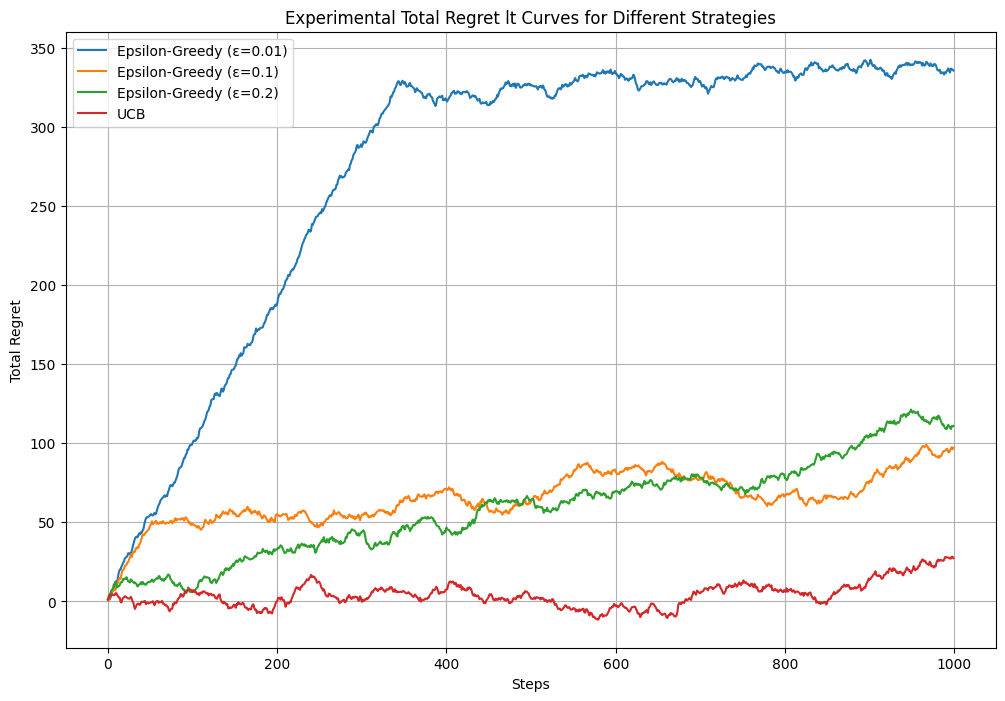

In [168]:
epsilon_values = [0.01, 0.1, 0.2]
experimental_lt_curves = {}

for epsilon in epsilon_values:
    _, _, lt_curve = k_bandit_problem(k, epsilon, 'EpsilonGreedy', true_means, n_steps)
    experimental_lt_curves[f'Epsilon-Greedy (ε={epsilon})'] = lt_curve

rewards, bandits, regrets = k_bandit_problem(k, epsilon, 'UCB', true_means, n_steps)
experimental_lt_curves['UCB'] = regrets

plt.figure(figsize=(12, 8))
for strategy_name, lt_curve in experimental_lt_curves.items():
    plt.plot(lt_curve, label=strategy_name)

plt.xlabel('Steps')
plt.ylabel('Total Regret')
plt.title('Experimental Total Regret lt Curves for Different Strategies')
plt.legend()
plt.grid(True)
plt.show()